#### Mateusz Rydzik, Geoinformacja II st.
#### 30.03.2023
---
# Analiza wielowymiarowa

Celem pracy było zbadanie potencjalnych zalezności między zmiennymi bioklimatycznymi, opisującymi własności temperatury oraz opadów, dla połozeń jabłoni na obszarze Europy. W ramach pracy wykorzystano dane o jabłoniach ze zbioru Global Biodiversity Information Facility oraz zbiór danych WorldClim 2 o rozdzielczości przestrzennej 5 minut, zawierający średnie wartości dla lat 1970-2000. Dane zostały udostępnione w formacie plików rastrowych. Do tego zbioru nalezą zmienne:

- AMT = Średnia roczna temperatura
- MDR = Średni zakres dobowy
- ISO = Izotermia 
- TSE = Sezonowość temperatury 
- MxTW = Najwyższa temperatura w najcieplejszym miesiącu
- MnTC = Najniższa temperatura w najzimniejszym miesiącu
- TAR = Roczny zakres temperatury
- MTWeQ = Średnia temperatura najbardziej mokrego kwartału
- MTDQ = Średnia temperatura najsuchszego kwartału
- MTWaQ = Średnia temperatura najcieplejszego kwartału
- MTCQ = Średnia temperatura najzimniejszego kwartału
#
- AP = Roczna suma opadów
- PWtM = Suma opadów w najbardziej mokrym miesiącu
- PDtM = Suma opadów w najsuchszym miesiącu
- PS = Sezonowość opadów
- PWtQ = Suma opadów w najbardziej mokrym kwartale
- PDtQ = Suma opadów w najsuchszym kwartale
- PWmQ = Suma opadów w najcieplejszym kwartale
- PCoQ = Suma opadów w najzimniejszym kwartale

Zmienne podzielono na dwie kategorie, opisujące własności temperatury i opadów. Do początkowej analizy zalezności wybrano zmienne TAR oraz AP.

In [1]:
import geopandas
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import contextily as cx
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import glob

# 1. Przygotowanie danych

## 1.1 Wczytanie i przetworzenie danych

Pierwszym etapem pracy było wyodrębnienie interesujących nas zmiennych. Następnie, konieczne było usunięcie powtarzających się wierszy oraz rekordów bez zanotowanych współrzędnych. Dla zwiększenia wydajności, zmniejszono populację z 250 000 do 25 000.

In [2]:
malus = pd.read_csv('data/gbif.csv', delimiter="\t")
malus = malus[["countryCode", "year", "stateProvince", "locality", "elevation", "elevationAccuracy", "decimalLatitude", "decimalLongitude"]]
malus.drop_duplicates(subset=["decimalLatitude", "decimalLongitude"], inplace=True)
malus = malus[malus['decimalLatitude'].notna() | malus['decimalLongitude'].notna()]
malus = malus.sample(n=25000)

/var/folders/bn/0w4p7_2d1dz9438_cmgrn6600000gn/T/ipykernel_41300/1706037447.py:1: DtypeWarning: Columns (45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  malus = pd.read_csv('data/gbif.csv', delimiter="\t")


## 1.2. Próbkowanie zmiennych

Po udanym etapie przetwarzania wartości, nalezało wykonać próbkowanie wartości zmiennych bioklimatycznych, zapisanych w formie rastrów, dla zbioru obserwacji.

Skrypt iteruje po wskazanym katalogu w poszukiwaniu plików o określonej nazwie. W wyniku iteracji po listach tworzony jest słownik, którego kluczami są nazwy kolejnych zmiennych, a wartości: odpowiadające im rastry zmiennych.

In [3]:
file_dir = 'wc2/'
file_pattern = 'wc2.1_5m_bio_*.tif'
file_paths = glob.glob(file_dir + '/' + file_pattern)
file_paths = sorted(file_paths, key=lambda x: int(x.split('_')[-1].split('.')[0]))

var_names = ['AMT', 'MDR', 'ISO', 'TSE', 'MxTW', 'MnTC', 'TAR', 'MTWeQ', 'MTDQ', 'MTWaQ', 'MTCQ', 'AP', 'PWtM', 'PDtM', 'PS', 'PWtQ', 'PDtQ', 'PWmQ', 'PCoQ']
variables = {}

for var_name, file_path in zip(var_names, file_paths):
    variables[var_name] = rasterio.open(file_path)

Po pozyskaniu listy współrzędnych dla obserwacji, mozliwe jest wykonanie procesu próbkowania wartości wskaźników bioklimatycznych oraz zapisaniu ich do kolejnych kolumn.

In [4]:
# pobranie współrzędnych punktów
malus = geopandas.read_file('data/gbif_clean.csv')
malus['geometry'] = geopandas.points_from_xy(malus.decimalLongitude, malus.decimalLatitude, crs="EPSG:4326")
coord_list = [(x,y) for x,y in zip(malus.geometry.x, malus.geometry.y)]

# próbkowanie po kolejnych zmiennych
for name, var in variables.items():
    malus[name] = [x.item() for x in var.sample(coord_list, masked = True)]
    malus[name][malus[name] < -10000] = None

/var/folders/bn/0w4p7_2d1dz9438_cmgrn6600000gn/T/ipykernel_41300/437435178.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  malus[name][malus[name] < -10000] = None
/var/folders/bn/0w4p7_2d1dz9438_cmgrn6600000gn/T/ipykernel_41300/437435178.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  malus[name][malus[name] < -10000] = None
/var/folders/bn/0w4p7_2d1dz9438_cmgrn6600000gn/T/ipykernel_41300/437435178.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

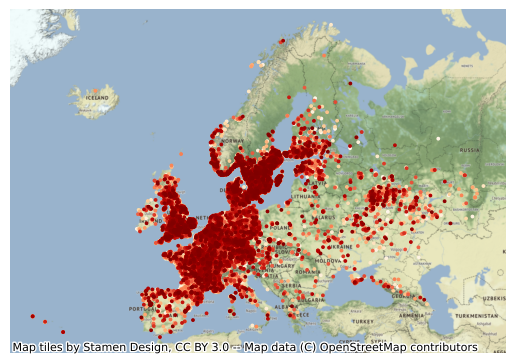

In [5]:
df_wm = malus.to_crs(epsg=3857)
ax = df_wm.plot(cmap='OrRd', markersize = 3)
ax.axis("off")
cx.add_basemap(ax)

Większość obserwacji zlokalizowana jest w zachodniej Europie. Duze skupiska odnotowano w południowych regionach Skandynawii i Wielkiej Brytanii, a takze na obszarze Francji i Niemiec.

# 2. Wstępna eksploracja danych

Do wstępnego określenia potencjalnych zalezności między dwoma grupami wskaźników, porównane zostały wartości dwóch wybranych wskaźników: rocznego zakresu temperatury oraz rocznej sumy opadów.

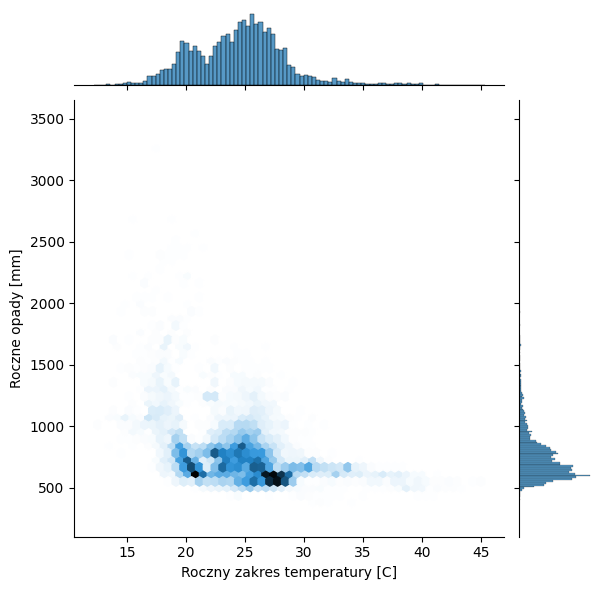

In [6]:
h = sns.jointplot(x='TAR',y='AP', kind="hex",data=malus)
h.ax_joint.set_xlabel("Roczny zakres temperatury [C]")
h.ax_joint.set_ylabel("Roczne opady [mm]")
plt.show()

Widoczna jest zalezność, polegająca na spadku rocznej sumy opadów wraz ze wzrostem rocznego zakresu temperatury.

Wartości zostały dodatkowo pogrupowane dla poszczególnych krajów.

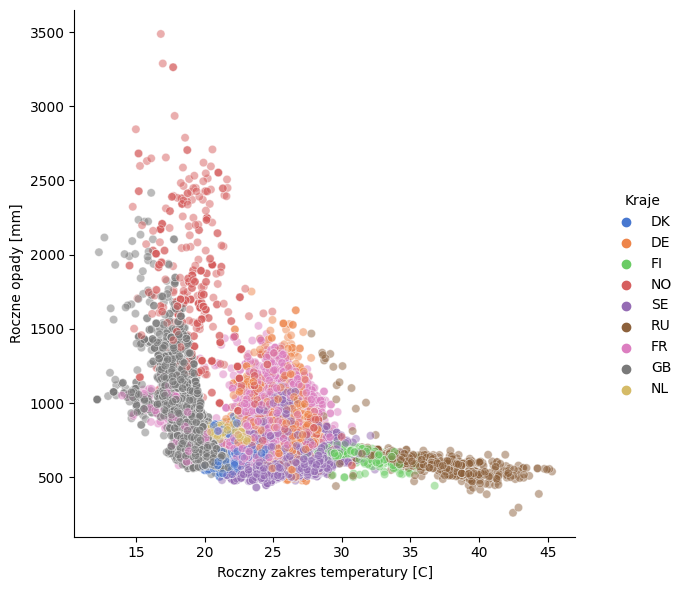

In [7]:
countries = ['NL', 'RU', 'FI', 'NO', 'DK', 'DE', 'FR', 'GB', 'SE']
malus_sel = malus.loc[malus['countryCode'].isin(countries)]

ax = sns.relplot(x='TAR', y='AP', hue='countryCode',
             alpha=.5, palette="muted",
            height=6, data=malus_sel)

ax.set(xlabel="Roczny zakres temperatury [C]", ylabel="Roczne opady [mm]")
ax._legend.set_title('Kraje')
plt.show()

Zauwazalne jest występowanie klastrów o podobnych kolorach, świądczacych o potencjalnym wpływie kategorii kraju na wartości. 

# 3. Analiza zalezności

Wstępna analiza dwóch zmiennych z osobnych grup wskazuje na potencjał występowania silnych korelacji między poszczególnymi wartościami. Daje to powód na wykonanie macierzy korelacji.

/var/folders/bn/0w4p7_2d1dz9438_cmgrn6600000gn/T/ipykernel_41300/18878509.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  kor = malus.corr()


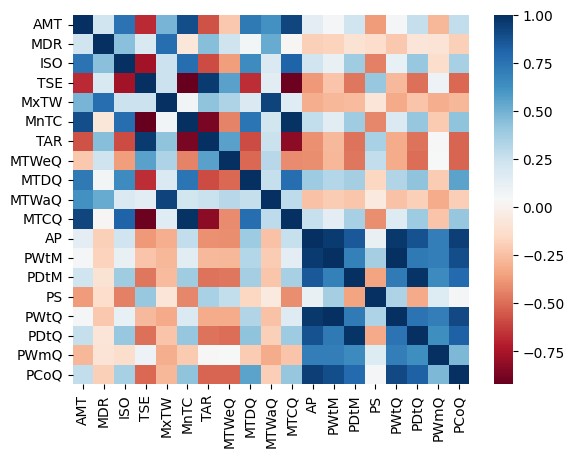

In [8]:
kor = malus.corr()
sns.heatmap(kor, 
            xticklabels=kor.columns.values,
            yticklabels=kor.columns.values,cmap="RdBu")
plt.show()

Zauwazalny jest podział macierzy na cztery prostokąty o podobnych zmiennościach. Zmienne opisujące opady cechują się wysoką korelacją pozytywną. Duze róznice występują w korelacjach między zmiennymi dotyczącymi temperatury. 

In [9]:
env = malus.iloc[:, 10:]
# standaryzacja danych
data_scaled = (env - env.mean()) / env.std()

pca = PCA()
imputer = SimpleImputer(strategy='median')
data_scaled = imputer.fit_transform(data_scaled)
pca.fit(data_scaled)

# składniki (loadings)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# wartości własne i procent wariacji wyjaśnianej przez składowe
eigenvalues = pca.explained_variance_
explained_var_ratio = pca.explained_variance_ratio_
# dwie pierwsze składowe
pca_df = pd.DataFrame(data = pca.transform(data_scaled)[:,0:2], columns = ['PC1', 'PC2'])
pca_df.index = env.index

Text(0.5, 1.0, '2 components, captures 50.0% of total variation')

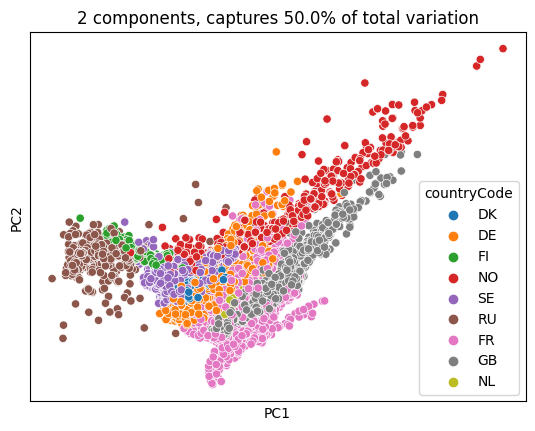

In [10]:
df_pca = pd.DataFrame({'PC1': pca_df.iloc[:,0], 'PC2': pca_df.iloc[:,1], 'countryCode': malus['countryCode']})
countries = ['NL', 'RU', 'FI', 'NO', 'DK', 'DE', 'FR', 'GB', 'SE']

df_pca_sel = df_pca.loc[df_pca['countryCode'].isin(countries)]

sns.scatterplot(x='PC1', y='PC2', hue="countryCode", data=df_pca_sel)
plt.xlabel('PC1'); plt.xticks([])
plt.ylabel('PC2'); plt.yticks([])
plt.title(f'2 components, captures {eigenvalues[1].round(2) * 10}% of total variation')

Wykonanie analizy głównych składowych pozwoliło ocenić wpływ poszczególnych kategorii krajów na składowe główne.

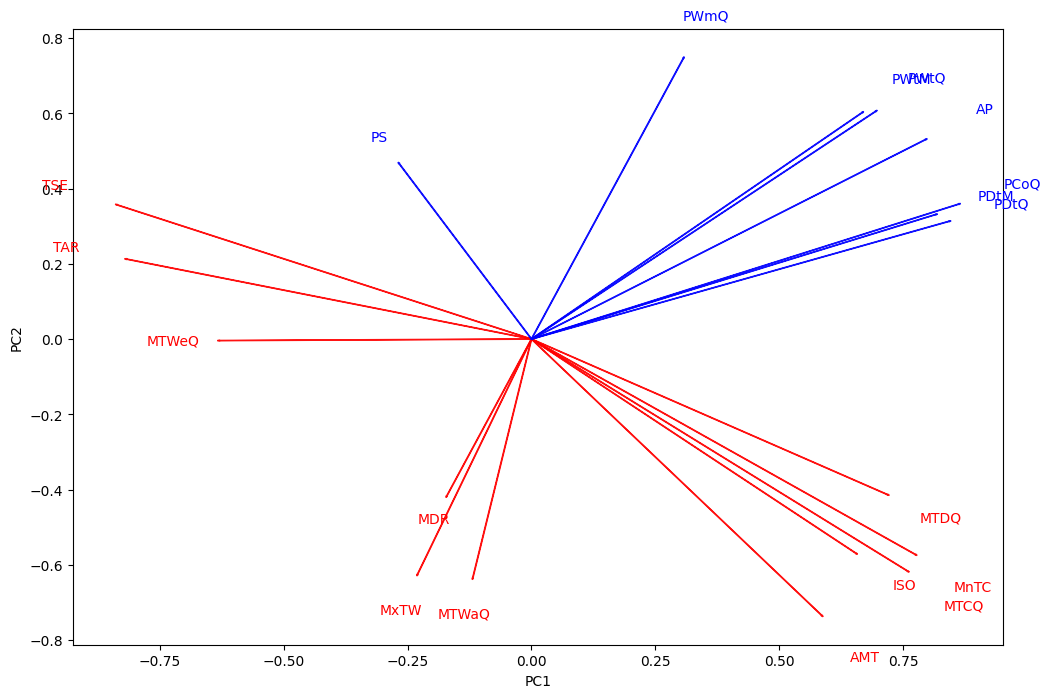

In [11]:
pca_df = pd.concat([pca_df, env.iloc[:,0:19]], axis = 1)
# loadings plot
fig, ax = plt.subplots(figsize = (12,8))
for i, (x, y) in enumerate(zip(loadings[:,0], loadings[:,1])):
    if i < 11:
        ax.arrow(0, 0, x, y, color = 'r', alpha = 0.9)
        ax.text(x * 1.15, y * 1.15, env.columns[i], color = 'r', ha = 'center', va = 'center')
    else:
        ax.arrow(0, 0, x, y, color = 'b', alpha = 0.9)
        ax.text(x * 1.15, y * 1.15, env.columns[i], color = 'b', ha = 'center', va = 'center')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Analiza głównych składowych wskazuje na brak pozytywnych korelacji między parą zmiennych z dwóch róznych grup. Istnieje natomiast wiele połączeń między zmiennymi opisującymi temperatury i opady o wysoce ujemnej korelacji. 

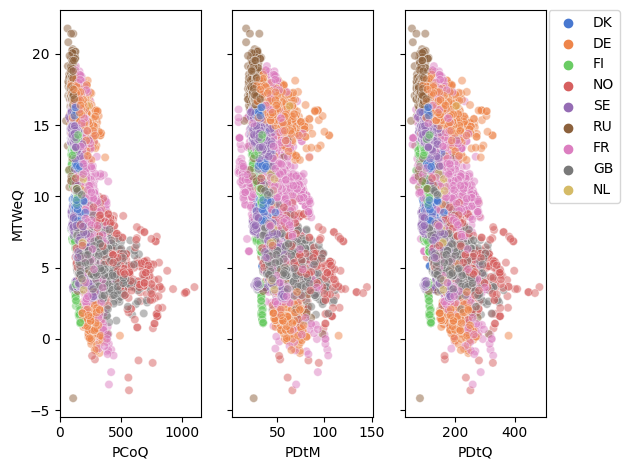

In [12]:
f, axs = plt.subplots(1,3,sharey=True)
sns.scatterplot(malus_sel, x="PCoQ", y="MTWeQ", ax=axs[0], hue="countryCode",alpha=.5, palette="muted", legend=False)
sns.scatterplot(malus_sel, x="PDtM", y="MTWeQ", ax=axs[1], hue="countryCode",alpha=.5, palette="muted", legend=False)
sns.scatterplot(malus_sel, x="PDtQ", y="MTWeQ", ax=axs[2], hue="countryCode",alpha=.5, palette="muted")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
f.tight_layout()

Średnia temperatura najbardziej mokrego kwartału posiadała trzy silne ujemne korelacje ze zmiennymi:
- Suma opadów w najzimniejszym kwartale
- Suma opadów w najsuchszym miesiącu
- Suma opadów w najsuchszym kwartale

Po zastosowaniu grupowania na kraje, zauwazalny jest podobny rozkład obserwacji.

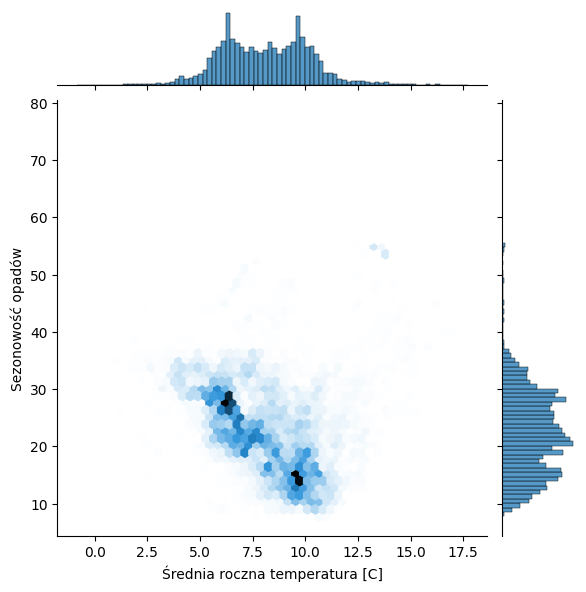

In [13]:
h = sns.jointplot(x='AMT',y='PS', kind="hex",data=malus)
h.ax_joint.set_xlabel("Średnia roczna temperatura [C]")
h.ax_joint.set_ylabel("Sezonowość opadów")
plt.show()

Zmienne średniej rocznej temperatury i sezonowości opadów posiadają podobny rozkład wartości. Cechują się takze silną korelacją ujemną.

# 4. Podsumowanie

Proces analizy zalezności między zmiennymi bioklimatycznymi, opisującymi własności temperatur oraz opadów wykazał silną korelacje między obydwiema grupami dla gatunku jabłoni. Cechą wspólną większości par porównań jest ujemna korelacja. Dodatkowo, odnotowano potencjalny wpływ kraju pochodzenia obserwacji na zachodzące zalezności. Praca ta wykazała potencjał do dalszej analizy danych bioklimatycznych w kontekście przestrzennym.